## Instructions: ##
  
1) Place this file at the root of the folder you started jupyter notebook in.  
2) Create a "data/" folder containing all turnstile data you want to parse.  

_Example Structure:_  
~~~~
/MTA_data_parser.ipynb  
/data  
/data/turnstile_180922.txt
~~~~

In [40]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import datetime
import requests
%matplotlib inline

# Put filepath here
data_path = 'data/'
fp = 'data/turnstile_180922.txt'
df = pd.read_csv(fp)
df = df.rename(columns=lambda x: x.strip())

In [62]:
# Download all log files given range

start = [2015,1,3]
end = [2018, 9, 23]
days_between = 7

def gen_dates(start, end, days_between):
    start = datetime.datetime(*start)
    end = datetime.datetime(*end)
    step = datetime.timedelta(days=days_between)
    dates = []
    
    while start < end:
        dates.append(start.strftime('%y%m%d'))
        start += step
    return dates

dates = gen_dates(start, end, days_between)

def download_logs(dates):
    for date in dates:
        print('Downloading', 'data/turnstile_' + date + '.txt')
        url = 'http://web.mta.info/developers/data/nyct/turnstile/turnstile_{}.txt'.format(date)
        response = requests.get(url)
        open('data/turnstile_' + date + '.txt', 'wb').write(response.content)
        
        break

download_logs(dates)

In [42]:
# Use to do preliminary inspection of data

def data_inspect(df, resampled=False):
    print("Summarize NAs:")
    print(df.isna().sum())
    
    u_station = df['STATION'].unique()
    print("\nNum Unique Stations:", len(u_station))
    print(u_station)
    
    u_desc = df['DESC'].unique()
    print("\n Unique Descriptions")
    print(u_desc)
    
    if resampled:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['DATETIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

    else:
        print("\nUnique Time Vals per station")
        for s in u_station:
            u_time = df[df['STATION'] == s]['TIME'].unique()
            print('Station:', s)
            print(u_time, '\n')

data_inspect(df)

Summarize NAs:
C/A         0
UNIT        0
SCP         0
STATION     0
LINENAME    0
DIVISION    0
DATE        0
TIME        0
DESC        0
ENTRIES     0
EXITS       0
dtype: int64

Num Unique Stations: 374
['59 ST' '5 AV/59 ST' '57 ST-7 AV' '49 ST' 'TIMES SQ-42 ST'
 '34 ST-HERALD SQ' '28 ST' '23 ST' '14 ST-UNION SQ' '8 ST-NYU' 'PRINCE ST'
 'CANAL ST' 'CITY HALL' 'CORTLANDT ST' 'RECTOR ST' 'WHITEHALL S-FRY'
 'DELANCEY/ESSEX' 'BOWERY' 'CHAMBERS ST' 'FULTON ST' 'BROAD ST' '7 AV'
 'PARK PLACE' 'BOTANIC GARDEN' 'PROSPECT PARK' 'PARKSIDE AV' 'CHURCH AV'
 'BEVERLEY ROAD' 'CORTELYOU RD' 'NEWKIRK PLAZA' 'AVENUE H' 'AVENUE J'
 'AVENUE M' 'KINGS HWY' 'AVENUE U' 'NECK RD' 'SHEEPSHEAD BAY'
 'BRIGHTON BEACH' 'OCEAN PKWY' 'BOROUGH HALL' 'JAY ST-METROTEC'
 'DEKALB AV' 'ATL AV-BARCLAY' 'UNION ST' '4AV-9 ST' 'PROSPECT AV' '25 ST'
 '36 ST' '45 ST' '53 ST' 'BAY RIDGE AV' '77 ST' '86 ST' 'BAY RIDGE-95 ST'
 '8 AV' 'FT HAMILTON PKY' 'NEW UTRECHT AV' '18 AV' '20 AV' 'BAY PKWY'
 '9 AV' '50 ST' '55 ST' '71 ST

Station: BOTANIC GARDEN
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '07:38:21'] 

Station: PROSPECT PARK
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '13:20:35' '14:23:49'] 

Station: PARKSIDE AV
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: CHURCH AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: BEVERLEY ROAD
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: CORTELYOU RD
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: NEWKIRK PLAZA
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: AVENUE H
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '09:15:43' '07:38:23'] 

Station: AVENUE J
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: AVENUE M
['00:00:00' '04:00:00' '08:00:00' '1

Station: NORWOOD AV
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: CRESCENT ST
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: CYPRESS HILLS
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 75 ST-ELDERTS
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '13:20:45' '14:24:02'] 

Station: 85 ST-FOREST PK
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: WOODHAVEN BLVD
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '13:23:31'] 

Station: 104 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 111 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '13:20:56' '14:24:11' '09:16:19' '10:20:55'] 

Station: 121 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:0

Station: QUEENS PLAZA
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: STEINWAY ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 46 ST
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '01:15:43' '09:16:34' '10:21:09'] 

Station: NORTHERN BLVD
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '09:16:38' '10:21:14' '08:34:26' '08:46:38'] 

Station: 65 ST
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: JKSN HT-ROOSVLT
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '09:52:14' '23:20:30' '23:45:37'] 

Station: ELMHURST AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '09:16:41' '10:21:18' '13:23:25' '14:26:09' '07:40:37' '07:52:01'
 '08:01:14'] 

Station: GRAND-NEWTOWN
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '09:16:48' '10:21:29'] 

Station: 63 DR-REGO PARK
['00:00:00' '04:00:00' '08:00:00' '

Station: TWENTY THIRD ST
['00:31:42' '04:43:42' '08:55:42' '13:07:42' '17:19:42' '21:31:42'
 '01:43:42' '05:55:42' '10:21:42' '14:33:42' '18:45:42' '22:57:42'
 '03:09:42' '07:21:42' '11:33:42' '15:59:42' '20:11:42' '00:23:42'
 '04:35:42' '08:47:42' '13:13:42' '17:25:42' '21:37:42' '01:49:42'
 '06:01:42' '10:13:42' '14:25:42' '18:37:42' '22:49:42' '03:01:42'
 '07:13:42' '11:25:42' '15:37:42' '19:49:42' '00:01:42' '04:13:42'
 '08:25:42' '12:37:42' '16:49:42' '21:01:42' '00:37:23' '04:49:23'
 '09:01:23' '13:13:23' '17:25:23' '21:37:23' '01:49:23' '06:01:23'
 '10:13:23' '14:25:23' '18:37:23' '22:49:23' '03:01:23' '07:13:23'
 '11:25:23' '15:37:23' '19:49:23' '00:01:23' '04:13:23' '08:25:23'
 '12:37:23' '16:49:23' '21:01:23' '01:13:23' '05:25:23' '09:37:23'
 '13:49:23' '18:01:23' '22:13:23' '02:25:23' '06:37:23' '10:49:23'
 '15:01:23' '19:13:23' '23:25:23' '03:37:23' '07:49:23' '12:01:23'
 '16:13:23' '20:25:23' '00:39:13' '04:51:13' '09:03:13' '13:15:13'
 '17:27:13' '21:39:13' '01:51:13' '06

Station: 66 ST-LINCOLN
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: 72 ST
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '09:17:26' '10:22:33'] 

Station: 116 ST-COLUMBIA
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: 137 ST CITY COL
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'
 '07:51:43' '08:00:59'] 

Station: 157 ST
['01:00:00' '05:00:00' '09:00:00' '13:00:00' '17:00:00' '21:00:00'] 

Station: 191 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 207 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '09:15:23' '09:17:29' '10:22:37'] 

Station: 215 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: MARBLE HILL-225
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 231 ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: 238 ST
['01:00:00'

Station: KINGSTON AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: CROWN HTS-UTICA
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'
 '11:28:42' '11:30:04' '11:31:23' '11:32:43' '11:34:14' '11:35:23'
 '11:36:43' '11:38:03' '11:39:23' '11:40:43' '11:22:02' '11:23:22'
 '11:24:42' '11:26:02' '11:27:22' '11:42:03' '11:43:23' '11:44:43'
 '11:46:03' '11:47:23' '11:48:44' '11:50:04' '12:22:28' '12:23:33'
 '12:24:35' '12:25:37' '12:26:40' '12:27:42'] 

Station: SUTTER AV-RUTLD
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: SARATOGA AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: JUNIUS ST
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: PENNSYLVANIA AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: NEW LOTS AV
['00:00:00' '04:00:00' '08:00:00' '12:00:00' '16:00:00' '20:00:00'] 

Station: PRESIDENT ST
['00:00:00' '04:00

In [43]:
# Organize data before using diff() to find absolute diff in entries/exits.
# Zero out counter rollovers (discard)
# Aggregate times to ensure 4 hour interval in-between

def clean_data(df):
    stop_data = {}
    u_station = df['STATION'].unique()
    
    group_order = ['C/A', 'STATION', 'UNIT', 'SCP', 'DATE', 'TIME']
    # Sort by Control Area (station), Unit (Remote unit), SCP (turnstile), Date, Time
    df = df.sort_values(by=group_order)
    
    # Substract next row by prev row for magnitude of change
    df['DIFF_ENTRY'] = df['ENTRIES'].diff()
    df['DIFF_EXIT'] = df['EXITS'].diff()
    
    # Add datetime col to resample data
    df['DATETIME'] = df['DATE'] + ' ' + df['TIME']
    df['DATETIME'] = pd.to_datetime(df['DATETIME'])
    
    df.loc[df['DIFF_ENTRY'] < 0, 'DIFF_ENTRY'] = 0
    df.loc[df['DIFF_ENTRY'] > 4000, 'DIFF_ENTRY'] = 0
    df.loc[df['DIFF_EXIT'] > 4000, 'DIFF_EXIT'] = 0
    df.loc[df['DIFF_EXIT'] < 0, 'DIFF_EXIT'] = 0
    
    for s in u_station:
        stop_data[s] = df[df['STATION'] == s][['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DIFF_EXIT', 'DATETIME']]
    
    pickle.dump(stop_data,open('stop_data', 'wb'))
    print('Done')
clean_data(df)

Done


14 ST
            DIFF_ENTRY  DIFF_EXIT
DATETIME                         
2018-09-15     26991.0    23202.0
2018-09-16     28922.0    21004.0
2018-09-17     59176.0    49459.0
2018-09-18     64836.0    52039.0
2018-09-19     59497.0    50057.0
2018-09-20     68042.0    57476.0
2018-09-21     68103.0    56931.0


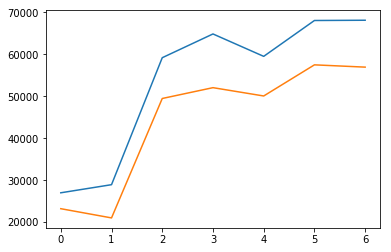

In [61]:
def plot_stop_data(fn):
    # Open from pickled data
    data = pickle.load(open(fn, 'rb'))
    
    i=10
    for stop in data:
        if stop== '14 ST':
            stop_data = data[stop]
            stop_data = stop_data[['C/A', 'UNIT', 'SCP', 'DIFF_ENTRY', 'DIFF_EXIT', 'DATETIME']]

            #resample
            grouped = stop_data.resample(rule='1D', on='DATETIME', base=0).sum()
            print(stop)
            print(grouped)
            amount_entry  = list(grouped['DIFF_ENTRY'])
            amount_exit = list(grouped['DIFF_EXIT'])
            plt.plot(amount_entry)
            plt.plot(amount_exit)
#         
#         if i==10:
#             break
#         i+=1
        
plot_stop_data('stop_data')

In [27]:
def first_last(df):
    # Priyanka's First-Last method
    turnstiles_df = df
    PREV_ENTRIES=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.first().reset_index()
    LAST=turnstiles_df.groupby(['C/A','UNIT','SCP','STATION','DATE']).ENTRIES.last().reset_index()
    PREV_ENTRIES['LAST']=LAST['ENTRIES']
    PREV_ENTRIES['DAILY']=PREV_ENTRIES['LAST']-PREV_ENTRIES['ENTRIES']
    ST59 = PREV_ENTRIES[PREV_ENTRIES['STATION'] == '59 ST']
    print(ST59.groupby(['DATE']).sum())
    
    PREV_ENTRIES=df.groupby(['C/A','UNIT','SCP','STATION','DATE']).EXITS.first().reset_index()
    LAST_x=df.groupby(['C/A','UNIT','SCP','STATION','DATE']).EXITS.last().reset_index()
    PREV_ENTRIES_x['LAST']=LAST_x['ENTRIES']
    PREV_ENTRIES_x['DAILY']=PREV_ENTRIES_x['LAST']-PREV_ENTRIES_x['ENTRIES']
    ST59_x = PREV_ENTRIES_x[PREV_ENTRIES_x['STATION'] == '59 ST']
#     print(ST59[['C/A','UNIT','SCP','STATION','DATE','DAILY']])
    
first_last(df)

               ENTRIES        LAST  DAILY
DATE                                     
09/15/2018  4163504941  4163534550  29609
09/16/2018  4163540211  4163563019  22808
09/17/2018  4163566964  4163623043  56079
09/18/2018  4163630086  4163685233  55147
09/19/2018  4163692211  4163743383  51172
09/20/2018  4163750571  4163810459  59888
09/21/2018  4163818798  4163877180  58382


AttributeError: 'DataFrameGroupBy' object has no attribute 'EXITS'